In [0]:
# Get dataset
#!wget -O "./GSE111933_Matrix_Avg_Beta.txt.gz" "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE111933&format=file&file=GSE111933%5FMatrix%5FAvg%5FBeta%2Etxt%2Egz"


In [0]:
# Extract dataset
#!gzip -d "./GSE111933_Matrix_Avg_Beta.txt.gz"

In [0]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt # NOTE: This was tested with matplotlib v. 2.1.0
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [3]:
# Read data from txt file
data = pd.read_csv("./GSE111933_Matrix_Avg_Beta.txt", sep='\t', low_memory=False)
data.set_index("ID_REF", inplace = True) 
data = data[data.columns[::2]]
# Replace blanks cells with 0.5 because that is the average value.
data = data.replace(r'^\s*$', 0.5, regex=True) 
data[data.columns] = data[data.columns].astype(float)

# visualize data
print(data.head())
print(data.shape)


               U909N     U912N     U913N  ...     U118T     U134T     U143T
ID_REF                                    ...                              
cg00000029  0.275748  0.285988  0.504508  ...  0.075581  0.098216  0.239315
cg00000108  0.921596  0.939222  0.928610  ...  0.912919  0.914881  0.914145
cg00000109  0.799066  0.857993  0.832321  ...  0.842779  0.893016  0.813091
cg00000165  0.157332  0.211416  0.144390  ...  0.877090  0.078582  0.219039
cg00000236  0.752568  0.816236  0.847976  ...  0.873626  0.854500  0.764874

[5 rows x 92 columns]
(485577, 92)


In [0]:
# import annotations (these allow for supervised learning and classify each point as either normal or tumerous)
# note, must upload series.csv file to jupyter notebook. series.csv file is in the github

# prepare annotations
annotations = pd.read_csv("series.csv")
annotations.set_index("Sample_title", inplace=True)
annotations = annotations.T
for i, age in enumerate(annotations["age"]):
    annotations["age"][i] = age[4:]
annotations["age"] = annotations["age"].astype(float)


In [0]:
# two methods colors and colors_from_age for initializing the cols variable which represents our target
def colors(headers):
    r = []
    for head in headers:
        if "N" in head:
            r.append('r')
        else:
            r.append('b')
    return r

def colors_from_age(ages):
    colors = ages - ages.min()
    colors *= (1/colors.max())
    return colors.to_numpy()
            
#initialize cols
# cols = colors_from_age(annotations["age"])
cols = colors(data.columns)


In [0]:
# initialize X_train, X_test, y_train, and y_test
X_train, X_test, y_train, y_test = train_test_split(data.T, cols, test_size=0.10, random_state=111)

In [53]:
# filter from 485577 features down to 5000 based on significance with respect to classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

print(X.shape)
selection = SelectKBest(score_func=chi2, k=5000).fit(X_train,y_train)
X_train = selection.transform(X_train).T
X_test = selection.transform(X_test).T
# X_train = SelectKBest(chi2, k=5000).fit_transform(X_train, y_train).T
print(X_test.shape)


(92, 485577)
(5000, 10)


In [0]:

# Center and scale the data (normalize the data)
scaled_data = preprocessing.scale(X_train.T)
scaled_test = preprocessing.scale(X_test.T)

In [0]:
pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data


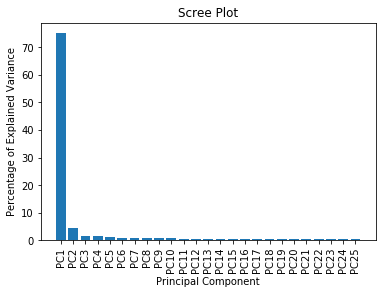

In [56]:
# Generate a scree plot on the first 25 pca components
per_var = (np.round(pca.explained_variance_ratio_* 100, decimals=1))[0:25]
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.xticks(rotation='vertical')
plt.show()

per_var = (np.round(pca.explained_variance_ratio_* 100, decimals=1))
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

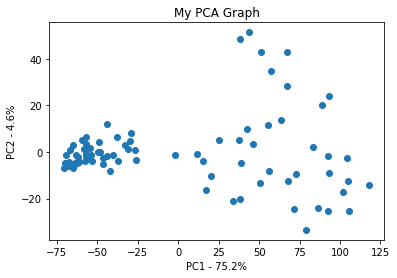

In [57]:
# plot pca in 2d space based on the first 2 principle components

# pca_df = pd.DataFrame(pca_data, index=[data.columns], columns=labels)
pca_df = pd.DataFrame(pca_data, columns=labels)

 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
# annotations if desired
# for sample in pca_df.index:
#     plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()


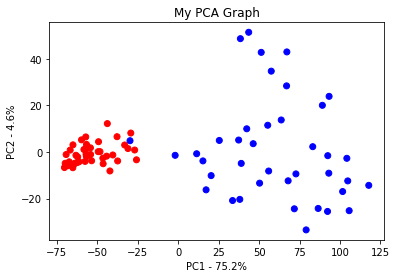

In [58]:
# same thing as above, but this time coloring the points based on classification / target

pca_df = pd.DataFrame(pca_data, columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2, c=y_train)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
# for sample in pca_df.index:
#     plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()

In [59]:
# fitting the support vector machine
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)
model.fit(np.array([pca_df.PC1, pca_df.PC2]).T, y_train)


SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
# function for visualizing support vector machine outcome (https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


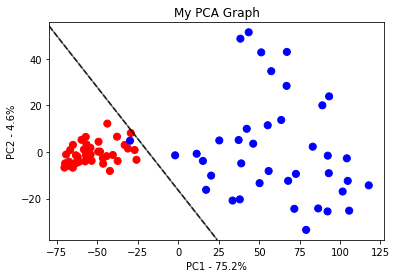

In [61]:
# Plot points and show graph

plt.scatter(pca_df.PC1, pca_df.PC2, c=y_train, s=50, cmap='autumn')
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plot_svc_decision_function(model);

In [94]:
# calculate accuracy of classification of test data.
print(scaled_test.shape)
pca_test = pca.transform(scaled_test).T
print(pca_test.shape)
pca_test = (pca_test[0:2]).T
print(pca_test.shape)

predicted = model.predict(pca_test)
print("Test set classification accuracy: " + str(metrics.accuracy_score(y_test, predicted)))

(10, 5000)
(82, 10)
(10, 2)
Test set classification accuracy: 1.0
